# Testing Auto-Transforms

### Old

In [ ]:
from PIL import Image
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torchvision import transforms
from model import U2NETP

In [5]:
# Single image paths-MRI
ACRIN_207837_MRI_path = "/Users/haleighoeser/Documents/MRIs/Originals/ACRIN 6698_207837/MRI PNGs/Brightness lvl5/png_00160.png"
ACRIN_277831_MRI_path = '/Users/haleighoeser/Documents/MRIs/Originals/ACRIN 6698_277831/MRI PNGs/Brightness level 6/png_00240.png'
Duke_62_MRI_path = '/Users/haleighoeser/Documents/MRIs/Originals/Duke_062/MRI PNGs/Brightness level 1/png_00246.png'
Duke_77_MRI_path = '/Users/haleighoeser/Documents/MRIs/Originals/Duke_077/MRI PNGs/Brightness level 1/png_00261.png'

# Single image paths-Segmentations
ACRIN_207837_Seg_path = '/Users/haleighoeser/Documents/MRIs/Originals/ACRIN 6698_207837/Seg PNGs/segpng_00160.png'
ACRIN_277831_Seg_path = '/Users/haleighoeser/Documents/MRIs/Originals/ACRIN 6698_277831/Seg PNGs/segpng_00240.png'
Duke_62_Seg_path = '/Users/haleighoeser/Documents/MRIs/Originals/Duke_062/Seg PNGs/segpng_00246.png'
Duke_77_Seg_path = '/Users/haleighoeser/Documents/MRIs/Originals/Duke_077/Seg PNGs/segpng_00261.png'

In [5]:
mri_207 = Image.open(ACRIN_207837_MRI_path)
mri_277 = Image.open(ACRIN_277831_MRI_path)
mri_62 = Image.open(Duke_62_MRI_path)
mri_77 = Image.open(Duke_77_MRI_path)

mri_207_arr = np.array(mri_207)
mri_277_arr = np.array(mri_277)
mri_62_arr = np.array(mri_62)
mri_77_arr = np.array(mri_77)

seg_207 = Image.open(ACRIN_207837_Seg_path)
seg_277 = Image.open(ACRIN_277831_Seg_path)
seg_62 = Image.open(Duke_62_Seg_path)
seg_77 = Image.open(Duke_77_Seg_path)

seg_207_arr = np.array(seg_207)
seg_277_arr = np.array(seg_277)
seg_62_arr = np.array(seg_62)
seg_77_arr = np.array(seg_77)

##### Size Transform

In [ ]:
a207_MRI = Image.open(ACRIN_207837_MRI_path)
a207_M_array = np.array(a207_MRI)
h, w = a207_M_array.shape

In [ ]:
def resize_image(image_path, new_width, new_height, output_path):
    img = Image.open(image_path)
    resized_img = img.resize((new_width, new_height), Image.LANCZOS)
    resized_img.save(output_path)
    
# traverse folders
output_path = "/Users/haleighoeser/Documents/MRIs/Resized"
input_path = "/Users/haleighoeser/Documents/MRIs/Originals"
mris = os.listdir(input_path)
for p in mris:
    b_path = f"{input_path}/{p}/MRI PNGs"
    b_levels = os.listdir(b_path).remove('.DS_Store')
    for b in b_levels:
        pngs = os.listdir(f"{b_path}/{b}")
        for i in pngs:
            image_path = f"{b_path}/{b}/{i}"
            resize_image(image_path, 320, 320, f"{output_path}/{p}/MRI PNGs/{b}/{i}")

##### Orientation Transform

In [31]:
def get_mask(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_size = image.shape[:2]     

    # Load U²-Net model
    model = U2NETP(3, 1)  # Make sure input and output channels match
    model.load_state_dict(torch.load("saved_models/u2netp.pth", map_location=torch.device("cpu")))
    model.eval()

    # Resize to match U²-Net input size (assumes 320x320, adjust if needed)
    image_resized = cv2.resize(image, (320, 320))

    # Normalize and convert to tensor
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    image_tensor = transform(image_resized).unsqueeze(0)  # Add batch dimension

    # Run the image through U²-Net
    with torch.no_grad():
        output = model(image_tensor)  # Get model output

    mask = output[0][0][0].cpu().numpy()  # Convert tensor to numpy
    mask = (mask - mask.min()) / (mask.max() - mask.min())  # Normalize to [0,1]
    mask = (mask * 255).astype(np.uint8)  # Convert to 8-bit format
    # Convert to binary mask
    _, mask_binary = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)

    return mask_binary

In [82]:
good_image = cv2.imread(ACRIN_277831_MRI_path)
bad_image = cv2.imread(Duke_62_MRI_path)
other_image = cv2.imread(Duke_77_MRI_path)
compare = cv2.imread(ACRIN_207837_MRI_path)

In [83]:
good_mask = get_mask(good_image)
bad_mask = get_mask(bad_image)
other_mask = get_mask(other_image)
compare_mask = get_mask(compare)

/var/folders/fh/3p72kl9960qd02pfdjfnkbh40000gn/T/ipykernel_71254/2795331452.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("saved_model

In [84]:
midpoint = len(compare_mask) // 2
c_mask = compare_mask.copy()
c_mask[midpoint:] = 0
c_mask_bot = np.flipud(c_mask)

In [85]:
good_mask_top = good_mask.copy()
good_mask_bot = good_mask.copy()
bad_mask_top = bad_mask.copy()
bad_mask_bot = bad_mask.copy()
other_mask_top = other_mask.copy()
other_mask_bot = other_mask.copy()

good_mask_top[midpoint:] = 0
good_mask_bot[:midpoint] = 0
bad_mask_top[midpoint:] = 0
bad_mask_bot[:midpoint] = 0
other_mask_top[midpoint:] = 0
other_mask_bot[:midpoint] = 0

In [86]:
g_top_acc = (good_mask_top == c_mask).astype(float).mean()
g_bot_acc = (good_mask_bot == c_mask_bot).astype(float).mean()
b_top_acc = (bad_mask_top == c_mask).astype(float).mean()
b_bot_acc = (bad_mask_bot == c_mask_bot).astype(float).mean()
o_top_acc = (other_mask_top == c_mask).astype(float).mean()
o_bot_acc = (other_mask_bot == c_mask_bot).astype(float).mean()

In [87]:
print(f"GOOD: top={g_top_acc} bot={g_bot_acc} | BAD: top={b_top_acc} bot={b_bot_acc} | OTHER: top={o_top_acc} bot={o_bot_acc}")

GOOD: top=0.8471875 bot=0.720595703125 | BAD: top=0.871875 bot=0.8683984375 | OTHER: top=0.866875 bot=0.892109375


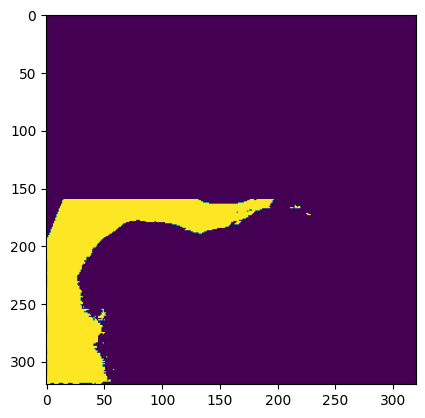

In [43]:
plt.imshow(good_mask_bot)

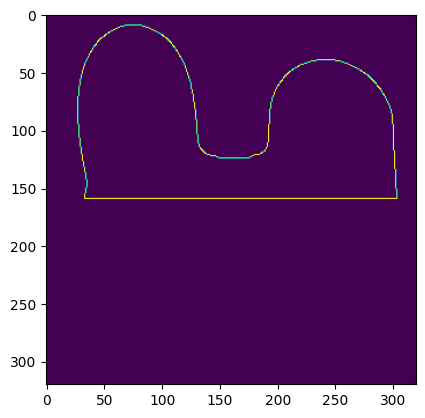

In [46]:
plt.imshow(edges)

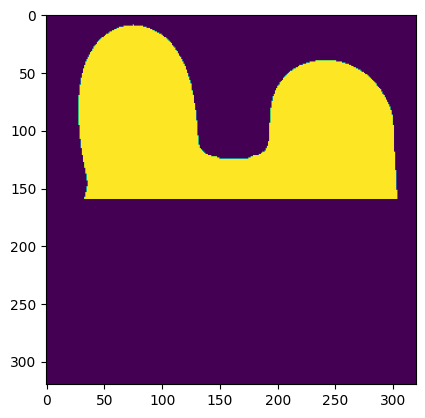

In [19]:
plt.imshow(c_mask)

##### Renumbering Transform

In [49]:
# Single image paths-MRI
ACRIN_207837_MRI_path_1 = "/Users/haleighoeser/Documents/MRIs/Originals/ACRIN 6698_207837/MRI PNGs/Brightness lvl5/png_00080.png"
ACRIN_277831_MRI_path_1 = '/Users/haleighoeser/Documents/MRIs/Originals/ACRIN 6698_277831/MRI PNGs/Brightness level 6/png_00120.png'
Duke_62_MRI_path_1 = '/Users/haleighoeser/Documents/MRIs/Originals/Duke_062/MRI PNGs/Brightness level 1/png_00123.png'
Duke_77_MRI_path_1 = '/Users/haleighoeser/Documents/MRIs/Originals/Duke_077/MRI PNGs/Brightness level 1/png_00130.png'

ACRIN_207837_MRI_path_2 = "/Users/haleighoeser/Documents/MRIs/Originals/ACRIN 6698_207837/MRI PNGs/Brightness lvl5/png_00240.png"
ACRIN_277831_MRI_path_2 = '/Users/haleighoeser/Documents/MRIs/Originals/ACRIN 6698_277831/MRI PNGs/Brightness level 6/png_00360.png'
Duke_62_MRI_path_2 = '/Users/haleighoeser/Documents/MRIs/Originals/Duke_062/MRI PNGs/Brightness level 1/png_00369.png'
Duke_77_MRI_path_2 = '/Users/haleighoeser/Documents/MRIs/Originals/Duke_077/MRI PNGs/Brightness level 1/png_00392.png'

# Single image paths-Segmentations
ACRIN_207837_Seg_path_1 = '/Users/haleighoeser/Documents/MRIs/Originals/ACRIN 6698_207837/Seg PNGs/segpng_00080.png'
ACRIN_277831_Seg_path_1 = '/Users/haleighoeser/Documents/MRIs/Originals/ACRIN 6698_277831/Seg PNGs/segpng_00120.png'
Duke_62_Seg_path_1 = '/Users/haleighoeser/Documents/MRIs/Originals/Duke_062/Seg PNGs/segpng_00123.png'
Duke_77_Seg_path_1 = '/Users/haleighoeser/Documents/MRIs/Originals/Duke_077/Seg PNGs/segpng_00130.png'

ACRIN_207837_Seg_path_2 = '/Users/haleighoeser/Documents/MRIs/Originals/ACRIN 6698_207837/Seg PNGs/segpng_00240.png'
ACRIN_277831_Seg_path_2 = '/Users/haleighoeser/Documents/MRIs/Originals/ACRIN 6698_277831/Seg PNGs/segpng_00360.png'
Duke_62_Seg_path_2 = '/Users/haleighoeser/Documents/MRIs/Originals/Duke_062/Seg PNGs/segpng_00369.png'
Duke_77_Seg_path_2 = '/Users/haleighoeser/Documents/MRIs/Originals/Duke_077/Seg PNGs/segpng_00392.png'

In [50]:
mri_207_1 = Image.open(ACRIN_207837_MRI_path_1)
mri_277_1 = Image.open(ACRIN_277831_MRI_path_1)
mri_62_1 = Image.open(Duke_62_MRI_path_1)
mri_77_1 = Image.open(Duke_77_MRI_path_1)

mri_207_2 = Image.open(ACRIN_207837_MRI_path_2)
mri_277_2 = Image.open(ACRIN_277831_MRI_path_2)
mri_62_2 = Image.open(Duke_62_MRI_path_2)
mri_77_2 = Image.open(Duke_77_MRI_path_2)

mri_207_arr_1 = np.array(mri_207_1)
mri_277_arr_1 = np.array(mri_277_1)
mri_62_arr_1 = np.array(mri_62_1)
mri_77_arr_1 = np.array(mri_77_1)

mri_207_arr_2 = np.array(mri_207_2)
mri_277_arr_2 = np.array(mri_277_2)
mri_62_arr_2 = np.array(mri_62_2)
mri_77_arr_2 = np.array(mri_77_2)

seg_207_1 = Image.open(ACRIN_207837_Seg_path_1)
seg_277_1 = Image.open(ACRIN_277831_Seg_path_1)
seg_62_1 = Image.open(Duke_62_Seg_path_1)
seg_77_1 = Image.open(Duke_77_Seg_path_1)

seg_207_2 = Image.open(ACRIN_207837_Seg_path_2)
seg_277_2 = Image.open(ACRIN_277831_Seg_path_2)
seg_62_2 = Image.open(Duke_62_Seg_path_2)
seg_77_2 = Image.open(Duke_77_Seg_path_2)

seg_207_arr_1 = np.array(seg_207_1)
seg_277_arr_1 = np.array(seg_277_1)
seg_62_arr_1 = np.array(seg_62_1)
seg_77_arr_1 = np.array(seg_77_1)

seg_207_arr_2 = np.array(seg_207_2)
seg_277_arr_2 = np.array(seg_277_2)
seg_62_arr_2 = np.array(seg_62_2)
seg_77_arr_2 = np.array(seg_77_2)

In [67]:
good_image_1 = cv2.imread(ACRIN_277831_MRI_path_1)
bad_image_1 = cv2.imread(Duke_77_MRI_path_1)
bad_image_1 = cv2.rotate(bad_image_1, cv2.ROTATE_180)
compare_1 = cv2.imread(ACRIN_207837_MRI_path_1)

good_seg_1 = cv2.imread(ACRIN_277831_Seg_path_1)
bad_seg_1 = cv2.imread(Duke_77_Seg_path_1)
compare_seg_1 = cv2.imread(ACRIN_207837_Seg_path_1)

good_image_2 = cv2.imread(ACRIN_277831_MRI_path_2)
bad_image_2 = cv2.imread(Duke_77_MRI_path_2)
bad_image_2 = cv2.rotate(bad_image_2, cv2.ROTATE_180)
compare_2 = cv2.imread(ACRIN_207837_MRI_path_2)

good_seg_2 = cv2.imread(ACRIN_277831_Seg_path_2)
bad_seg_2 = cv2.imread(Duke_77_Seg_path_2)
compare_seg_2 = cv2.imread(ACRIN_207837_Seg_path_2)

good_mask_1 = get_mask(good_image_1)
bad_mask_1 = get_mask(bad_image_1)
compare_mask_1 = get_mask(compare_1)

midpoint = len(compare_mask_1) // 2
good_mask_1[midpoint:] = 0
bad_mask_1[midpoint:] = 0
compare_mask_1[midpoint:] = 0

good_seg_mask_1 = get_mask(good_seg_1)
bad_seg_mask_1 = get_mask(bad_seg_1)
compare_seg_mask_1 = get_mask(compare_seg_1)

good_mask_2 = get_mask(good_image_2)
bad_mask_2 = get_mask(bad_image_2)
compare_mask_2 = get_mask(compare_2)

good_mask_2[midpoint:] = 0
bad_mask_2[midpoint:] = 0
compare_mask_2[midpoint:] = 0

good_seg_mask_2 = get_mask(good_seg_2)
bad_seg_mask_2 = get_mask(bad_seg_2)
compare_seg_mask_2 = get_mask(compare_seg_2)

/var/folders/fh/3p72kl9960qd02pfdjfnkbh40000gn/T/ipykernel_39153/2795331452.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("saved_model

In [68]:
g_acc_1 = (good_mask_1 == good_seg_mask_1).astype(float).mean()
g_acc_2 = (good_mask_2 == good_seg_mask_2).astype(float).mean()
g_acc_12 = (good_mask_1 == good_seg_mask_2).astype(float).mean()
g_acc_21 = (good_mask_2 == good_seg_mask_1).astype(float).mean()

b_acc_1 = (bad_mask_1 == bad_seg_mask_1).astype(float).mean()
b_acc_2 = (bad_mask_2 == bad_seg_mask_2).astype(float).mean()
b_acc_12 = (bad_mask_1 == bad_seg_mask_2).astype(float).mean()
b_acc_21 = (bad_mask_2 == bad_seg_mask_1).astype(float).mean()

c_acc_1 = (compare_mask_1 == compare_seg_mask_1).astype(float).mean()
c_acc_2 = (compare_mask_2 == compare_seg_mask_2).astype(float).mean()
c_acc_12 = (compare_mask_1 == compare_seg_mask_2).astype(float).mean()
c_acc_21 = (compare_mask_2 == compare_seg_mask_1).astype(float).mean()

In [76]:
print(f"B1: {g_acc_1} | B2: {g_acc_2} | B1to2: {g_acc_12} | B2to1: {g_acc_21} | COMPARE: {g_acc_1 + g_acc_2} - {g_acc_12 + g_acc_21}")
print(f"G1: {b_acc_1} | G2: {b_acc_2} | G1to2: {b_acc_12} | G2to1: {b_acc_21} | COMPARE: {b_acc_1 + b_acc_2} - {b_acc_12 + b_acc_21}")
print(f"C1: {c_acc_1} | C2: {c_acc_2} | C1to2: {c_acc_12} | C2to1: {c_acc_21} | COMPARE: {c_acc_1 + c_acc_2} - {c_acc_12 + c_acc_21}")

B1: 0.88314453125 | B2: 0.9080078125 | B1to2: 0.958896484375 | B2to1: 0.983505859375 | COMPARE: 1.7911523437499999 - 1.94240234375
G1: 0.986865234375 | G2: 0.98796875 | G1to2: 0.947431640625 | G2to1: 0.94845703125 | COMPARE: 1.974833984375 - 1.8958886718749999
C1: 0.855185546875 | C2: 0.919423828125 | C1to2: 0.88765625 | C2to1: 0.8166015625 | COMPARE: 1.774609375 - 1.7042578125


In [98]:
path = "/Users/haleighoeser/Documents/MRIs/Originals/Duke_062"
r = check_renumbering(path, True)

/var/folders/fh/3p72kl9960qd02pfdjfnkbh40000gn/T/ipykernel_39153/2795331452.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("saved_model

In [99]:
r

False

### Actual Code to use

In [1]:
from PIL import Image
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd


import torch
from torchvision import transforms
from model import U2NETP

In [2]:
def resize_image(image_path, new_width, new_height, output_path):
    img = Image.open(image_path)
    resized_img = img.resize((new_width, new_height), Image.LANCZOS)
    resized_img.save(output_path)

In [3]:
def get_mask(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_size = image.shape[:2]     

    # Load U²-Net model
    model = U2NETP(3, 1)  # Make sure input and output channels match
    model.load_state_dict(torch.load("saved_models/u2netp.pth", map_location=torch.device("cpu")))
    model.eval()

    # Resize to match U²-Net input size (assumes 320x320, adjust if needed)
    image_resized = cv2.resize(image, (320, 320))

    # Normalize and convert to tensor
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    image_tensor = transform(image_resized).unsqueeze(0)  # Add batch dimension

    # Run the image through U²-Net
    with torch.no_grad():
        output = model(image_tensor)  # Get model output

    mask = output[0][0][0].cpu().numpy()  # Convert tensor to numpy
    mask = (mask - mask.min()) / (mask.max() - mask.min())  # Normalize to [0,1]
    mask = (mask * 255).astype(np.uint8)  # Convert to 8-bit format
    # Convert to binary mask
    _, mask_binary = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)

    return mask_binary

In [4]:
def check_renumbering(patient_path, reorientation):
    segs = os.listdir(f"{patient_path}/Seg PNGs")
    if segs.__contains__('.DS_Store'):
        segs.remove('.DS_Store')
    num_slices = len(segs)
    first_quarter = num_slices // 4
    last_quarter = num_slices - first_quarter
    first_quarter = str(first_quarter).zfill(5)
    last_quarter = str(last_quarter).zfill(5)

    bright_levels = os.listdir(f"{patient_path}/MRI PNGs")
    if bright_levels.__contains__('.DS_Store'):
        bright_levels.remove('.DS_Store')
    bright_level = bright_levels[0]
    
    image_path_first = f"{patient_path}/MRI PNGs/{bright_level}/png_{first_quarter}.png"
    image_path_second = f"{patient_path}/MRI PNGs/{bright_level}/png_{last_quarter}.png"
    seg_path_first = f'{patient_path}/Seg PNGs/segpng_{first_quarter}.png'
    seg_path_second = f'{patient_path}/Seg PNGs/segpng_{last_quarter}.png'

    image_first = cv2.imread(image_path_first)
    image_second = cv2.imread(image_path_second)
    seg_first = cv2.imread(seg_path_first)
    seg_second = cv2.imread(seg_path_second)

    if reorientation:
        image_first = cv2.rotate(image_first, cv2.ROTATE_180)
        image_second = cv2.rotate(image_second, cv2.ROTATE_180)
        seg_first = cv2.rotate(seg_first, cv2.ROTATE_180)
        seg_second = cv2.rotate(seg_second, cv2.ROTATE_180)

    image_mask_first = get_mask(image_first)
    image_mask_second = get_mask(image_second)
    seg_mask_first = get_mask(seg_first)
    seg_mask_second = get_mask(seg_second)

    midpoint = len(image_mask_first) // 2
    image_mask_first[midpoint:] = 0
    image_mask_second[midpoint:] = 0
    seg_mask_first[midpoint:] = 0
    seg_mask_second[midpoint:] = 0

    acc_1 = (image_mask_first == seg_mask_first).astype(float).mean()
    acc_2 = (image_mask_second == seg_mask_second).astype(float).mean()
    acc_12 = (image_mask_first == seg_mask_second).astype(float).mean()
    acc_21 = (image_mask_second == seg_mask_first).astype(float).mean()

    correct = acc_1 + acc_2
    incorrect = acc_12 + acc_21

    check = correct - incorrect

    if check < 0:
        return True
    else:
        return False
    

In [5]:
def check_size(image_path):
    image = cv2.imread(image_path)
    h, w, c = image.shape
    if h != 320 or w != 320:
        return True
    else:
        return False

In [6]:
def check_reorientation(image_path, compare_path):
    image = cv2.imread(image_path)
    compare = cv2.imread(compare_path)

    image_mask = get_mask(image)
    compare_mask = get_mask(compare)

    midpoint = len(compare_mask) // 2
    c_mask = compare_mask.copy()
    c_mask[midpoint:] = 0
    c_mask_bot = np.flipud(c_mask)

    mask_top = image_mask.copy()
    mask_bot = image_mask.copy()

    mask_top[midpoint:] = 0
    mask_bot[:midpoint] = 0

    top_acc = (mask_top == c_mask).astype(float).mean()
    bot_acc = (mask_bot == c_mask_bot).astype(float).mean()

    if top_acc > bot_acc:
        return False
    else:
        return True
    

In [9]:
patients = pd.read_csv("/home/ra-ugrad/Documents/Haleigh/MedSegmentDeploy/preprocessing.csv")
map_bool = {"Yes": True, "No": False}
patients['Reorientation'] = patients.Reorientation.map(map_bool)
patients['Renumber'] = patients.Renumber.map(map_bool)
patients

,Patient ID,Renumber,Reorientation
0,000129_2022-08-12,False,False
1,000133_2022-09-09,False,False
2,000133_2022-10-05_vol133,False,False
3,000165_2022-08-19,False,False
4,000198_2023-04-10_ARFIpatient2,False,False
...,...,...,...
57,Rachel_Duke_003,True,True
58,Rachel_Duke_015,False,False
59,Rachel_Duke_023,True,False
60,Rachel_Duke_052,True,False


In [28]:
# traverse folders & save results
# output_path = "/Users/haleighoeser/Documents/MRIs/Resized"
input_path = "/home/ra-ugrad/Documents/Segmentations-Originals"
compare_path = '/home/ra-ugrad/Documents/Segmentations-Originals/ACRIN 6698_277831/MRI PNGs/Brightness level 6/png_00240.png'
# compare_path = "/Users/haleighoeser/Documents/MRIs/Originals/ACRIN 6698_207837/MRI PNGs/Brightness lvl5/png_00160.png"
results = dict()

mris = os.listdir(input_path)
if mris.__contains__('.DS_Store'):
    mris.remove('.DS_Store')
for p in mris:
    print(p)
    row_index = patients.index[patients['Patient ID'] == p][0]
    b_path = f"{input_path}/{p}/MRI PNGs"
    b_levels = os.listdir(b_path)
    if b_levels.__contains__('.DS_Store'):
        b_levels.remove('.DS_Store')
    b_1 = b_levels[0]

    # check for data preprocessing
    pngs = os.listdir(f"{b_path}/{b_1}")
    if pngs.__contains__('.DS_Store'):
        pngs.remove('.DS_Store')

    num_slices = len(pngs)
    half = num_slices // 2
    mri_50 = f"{b_path}/{b_1}/png_{str(half).zfill(5)}.png"
    size = check_size(mri_50)
    number = check_renumbering(f"{input_path}/{p}", patients.loc[row_index].Reorientation)
    reorient = check_reorientation(mri_50, compare_path)

    results[p] = {"Size": size, "Number": number, "Orient": reorient}
    
    # for b in b_levels:
    #     pngs = os.listdir(f"{b_path}/{b}")
    #     for i in pngs:
    #         image_path = f"{b_path}/{b}/{i}"
    #         if size:
    #             resize_image(image_path, 320, 320, f"{output_path}/{p}/MRI PNGs/{b}/{i}")
    #         # add reorientation
    #         # add renumbering


Duke_257


/usr/lib/python3/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


000198_2023-04-10_ARFIpatient2
Duke_106
Duke_114
ACRIN 6698_742356
Rachel_Duke_052
Duke_084
Brianne_Duke_038
Duke_077
Duke_337
Duke_129
Duke_191
000129_2022-08-12
Rachel_Duke_015
Duke_314
Duke_328
Duke_075
Duke_281
Duke_133
ACRIN_564701
ACRIN 6698_283070
Duke_201
Duke_172
Rachel_Duke_023
Estee_Duke_014
Duke_068
ACRIN 6698_277831
Duke_102
Duke_262
Duke_147
Duke_319
Duke_223
ACRIN 6998_649198
000133_2022-09-09
ACRIN 6698_253531
Duke_079
Rachel_Duke_003
ACRIN 6698_378885
Brianne_ACRIN 6698-414844
ACRIN_6698_220471_everyone
Duke_326
Duke_099
Duke_104
000133_2022-10-05_vol133
Nicole_Duke_047
Estee_Duke_033
Duke_218
Duke_196
Duke_189
Rachel_Duke_054
Duke_072
Duke_371
Duke_081
Duke_094
Duke_062
ACRIN 6698_207837
Duke_078
000165_2022-08-19
duke_patient001axdyn3
Duke_112
Duke_109
ACRIN 6698_932998


In [29]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Patient ID'})
all_data = pd.merge(patients, results_df, on="Patient ID")

In [30]:
all_data

,Patient ID,Renumber,Reorientation,Size,Number,Orient
0,000129_2022-08-12,False,False,True,False,True
1,000133_2022-09-09,False,False,True,False,True
2,000133_2022-10-05_vol133,False,False,True,False,False
3,000165_2022-08-19,False,False,True,True,True
4,000198_2023-04-10_ARFIpatient2,False,False,True,False,False
...,...,...,...,...,...,...
57,Rachel_Duke_003,True,True,True,False,True
58,Rachel_Duke_015,False,False,True,False,False
59,Rachel_Duke_023,True,False,True,True,False
60,Rachel_Duke_052,True,False,True,True,False


In [31]:
all_data.to_csv("preprocess_acc_check.csv")